In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Desáfio métricas

## Loans Dataset

### Carregar os dados

In [2]:
df = pd.read_csv('../data/loans.csv', index_col="id").reset_index(drop=True)
df.head()

,issue_d,sub_grade,term,home_ownership,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,...,pub_rec_bankruptcies,addr_state,initial_list_status,fico_range_high,revol_bal,open_acc,emp_length,loan_status,time_to_earliest_cr_line,loan_status_numeric
0,2016-07-012014-01-01,A4D1,36 months 60 months,MORTGAGEMORTGAGE,1490.0,31.0,0.0,98.8,146122.0,24.98,...,0.0,TXAR,wf,1498.0,21530.0,16.0,13.0,2.0,1267660.8,2
1,2016-07-012014-01-01,B5C4,36 months 60 months,RENTMORTGAGE,1400.0,51.0,0.0,162.9,127000.0,27.10,...,0.0,CAVT,wf,1408.0,13669.0,19.0,9.0,2.0,836352.0,2
2,2016-07-012014-01-01,D2A4,36 months 36 months,MORTGAGERENT,1360.0,64.0,1.0,52.3,115000.0,25.89,...,1.0,AZTX,ww,1368.0,13141.0,33.0,4.0,2.0,1007337.6,2
3,2016-07-012014-01-01,A1D1,36 months 60 months,RENTMORTGAGE,1405.0,62.0,0.0,83.9,184000.0,22.31,...,0.0,CAIN,wf,1413.0,40085.0,25.0,12.0,2.0,1020470.4,2
4,2016-07-012014-01-01,C4C3,60 months 36 months,MORTGAGEMORTGAGE,1380.0,29.0,1.0,111.4,167000.0,29.47,...,0.0,OHLA,wf,1388.0,6754.0,20.0,4.0,1.0,896832.0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92781 entries, 0 to 92780
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   issue_d                   92781 non-null  object 
 1   sub_grade                 92781 non-null  object 
 2   term                      92781 non-null  object 
 3   home_ownership            92781 non-null  object 
 4   fico_range_low            92781 non-null  float64
 5   total_acc                 92781 non-null  float64
 6   pub_rec                   92781 non-null  float64
 7   revol_util                92781 non-null  float64
 8   annual_inc                92781 non-null  float64
 9   int_rate                  92781 non-null  float64
 10  dti                       92781 non-null  float64
 11  purpose                   92781 non-null  object 
 12  mort_acc                  92781 non-null  float64
 13  loan_amnt                 92781 non-null  float64
 14  applic

### Processar colunas sub_grade e term

In [4]:
df['sub_grade'] = df['sub_grade'].astype('string')

# Cria uma cópia do DataFrame
df_copy = df.copy()

# Separa o sub_grade e coloca em um novo dataframe
df_copy['sub_grade'] = df['sub_grade'].str.split('([A-Z][1-9])', expand=True)[3]
df['sub_grade'] = df['sub_grade'].str.split('([A-Z][1-9])', expand=True)[1]

df_copy['term'] = df['term'].str.strip().str.split(' ', expand=True)[2] + ' months'
df['term'] = df['term'].str.strip().str.split(' ', expand=True)[0] + ' months'

df = pd.concat([df, df_copy], axis=0)

del df_copy

df.head()

,issue_d,sub_grade,term,home_ownership,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,...,pub_rec_bankruptcies,addr_state,initial_list_status,fico_range_high,revol_bal,open_acc,emp_length,loan_status,time_to_earliest_cr_line,loan_status_numeric
0,2016-07-012014-01-01,A4,36 months,MORTGAGEMORTGAGE,1490.0,31.0,0.0,98.8,146122.0,24.98,...,0.0,TXAR,wf,1498.0,21530.0,16.0,13.0,2.0,1267660.8,2
1,2016-07-012014-01-01,B5,36 months,RENTMORTGAGE,1400.0,51.0,0.0,162.9,127000.0,27.10,...,0.0,CAVT,wf,1408.0,13669.0,19.0,9.0,2.0,836352.0,2
2,2016-07-012014-01-01,D2,36 months,MORTGAGERENT,1360.0,64.0,1.0,52.3,115000.0,25.89,...,1.0,AZTX,ww,1368.0,13141.0,33.0,4.0,2.0,1007337.6,2
3,2016-07-012014-01-01,A1,36 months,RENTMORTGAGE,1405.0,62.0,0.0,83.9,184000.0,22.31,...,0.0,CAIN,wf,1413.0,40085.0,25.0,12.0,2.0,1020470.4,2
4,2016-07-012014-01-01,C4,60 months,MORTGAGEMORTGAGE,1380.0,29.0,1.0,111.4,167000.0,29.47,...,0.0,OHLA,wf,1388.0,6754.0,20.0,4.0,1.0,896832.0,1


### Valores nulos

In [5]:
df.isnull().any()

issue_d                     False
sub_grade                   False
term                        False
home_ownership              False
fico_range_low              False
total_acc                   False
pub_rec                     False
revol_util                  False
annual_inc                  False
int_rate                    False
dti                         False
purpose                     False
mort_acc                    False
loan_amnt                   False
application_type            False
installment                 False
verification_status         False
pub_rec_bankruptcies        False
addr_state                  False
initial_list_status         False
fico_range_high             False
revol_bal                   False
open_acc                    False
emp_length                  False
loan_status                 False
time_to_earliest_cr_line    False
loan_status_numeric         False
dtype: bool

### Tratar dados categóricos

In [6]:
# Dropar coluna issue_d, irrelevante
df.drop(columns=["issue_d", 'loan_status_numeric'], inplace=True, axis=1)

df['loan_status'] = df['loan_status'].astype('uint8')

# Pegar colunas categóricas
category_columns = df.select_dtypes(include=["object", "string"]).columns

# Transformar colunas categóricas em numéricas
for column in category_columns:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])

df.head()

,sub_grade,term,home_ownership,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,dti,...,verification_status,pub_rec_bankruptcies,addr_state,initial_list_status,fico_range_high,revol_bal,open_acc,emp_length,loan_status,time_to_earliest_cr_line
0,3,0,3,1490.0,31.0,0.0,98.8,146122.0,24.98,22.41,...,2,0.0,1853,2,1498.0,21530.0,16.0,13.0,2,1267660.8
1,9,0,10,1400.0,51.0,0.0,162.9,127000.0,27.10,51.23,...,8,0.0,213,2,1408.0,13669.0,19.0,9.0,2,836352.0
2,16,0,5,1360.0,64.0,1.0,52.3,115000.0,25.89,33.54,...,3,1.0,164,3,1368.0,13141.0,33.0,4.0,2,1007337.6
3,0,0,10,1405.0,62.0,0.0,83.9,184000.0,22.31,36.05,...,5,0.0,185,2,1413.0,40085.0,25.0,12.0,2,1020470.4
4,13,1,3,1380.0,29.0,1.0,111.4,167000.0,29.47,31.77,...,8,0.0,1513,2,1388.0,6754.0,20.0,4.0,1,896832.0


### Dropar colunas

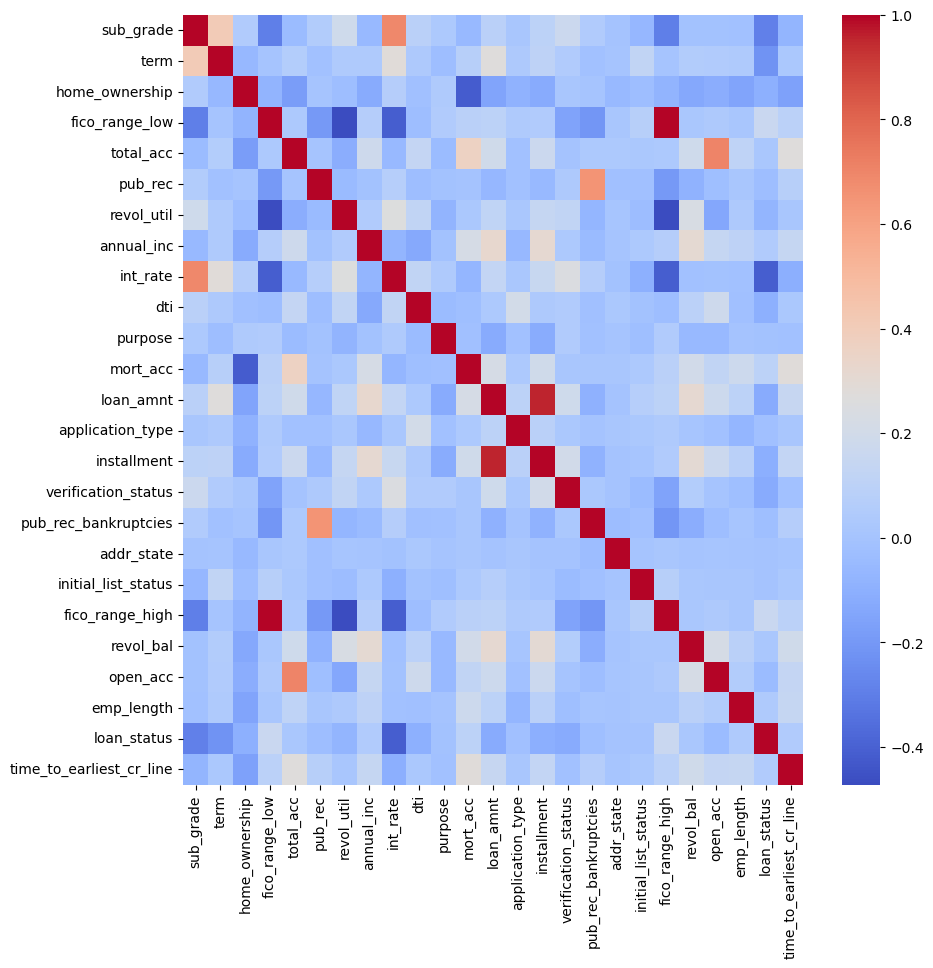

In [7]:
corr = df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.show()

As colunas "fico_range_low" e "fico_range_high", assim como "loan_amnt" e "installment", apresentam uma alta correlação. Optamos por remover uma de cada par para evitar redundâncias.

In [8]:
columns_to_remove = ['fico_range_high', 'installment']
df.drop(columns=columns_to_remove, inplace=True, axis=1)

### Separar em Features e Labels

In [9]:
X, y = df.drop(columns=["loan_status"]), df["loan_status"]

### Balançeamento de classes

In [10]:
df['loan_status'].value_counts(normalize=True)

loan_status
2    0.735334
1    0.243908
0    0.020759
Name: proportion, dtype: float64

In [11]:
rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_resample(X, y)

y_res.value_counts(normalize=True), y_res.shape

(loan_status
 0    0.333333
 1    0.333333
 2    0.333333
 Name: proportion, dtype: float64,
 (11556,))

### Separar em treino e teste

In [12]:
# Treino e teste balanceados

X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res,
                                                                    test_size=0.2, random_state=42)

# Treino e teste desbalanceados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Seleção de parâmetros e do modelo

In [13]:
""" params = [
    {'n_estimators': [10, 50, 100, 200, 500], 'criterion': ['gini', 'entropy']},
]

models = [RandomForestClassifier()]

for model, param in zip(models, params):
    grid = GridSearchCV(model, param, cv=5, n_jobs=-1)
    grid.fit(X_res_train, y_res_train)
    print(f"{model.__class__.__name__} : {grid.best_params_}") """

' params = [\n    {\'n_estimators\': [10, 50, 100, 200, 500], \'criterion\': [\'gini\', \'entropy\']},\n]\n\nmodels = [RandomForestClassifier()]\n\nfor model, param in zip(models, params):\n    grid = GridSearchCV(model, param, cv=5, n_jobs=-1)\n    grid.fit(X_res_train, y_res_train)\n    print(f"{model.__class__.__name__} : {grid.best_params_}") '

### Treinar os modelos e realizar classificação

In [14]:
rf_res = RandomForestClassifier(n_estimators=500, criterion='entropy')
rf = RandomForestClassifier(n_estimators=500, criterion='entropy')

# Treino dos modelos
rf_res.fit(X_res_train, y_res_train)
rf.fit(X_train, y_train)

# Predição dos modelos
predict_rf_res = rf_res.predict(X_res_test)
predict_rf = rf.predict(X_test)

### Avaliação

In [15]:
predicts = [predict_rf_res, predict_rf]
names = ["RF Balanced", "RF"]
ys = [y_res_test, y_test]

accuracies = []
precisions = []
recalls = []
f1s = []

for current_y, predict in zip(ys, predicts):
    accuracies.append(accuracy_score(current_y, predict) * 100)
    precisions.append(precision_score(current_y, predict, average='macro') * 100)
    recalls.append(recall_score(current_y, predict, average='macro') * 100)
    f1s.append(f1_score(current_y, predict, average='macro') * 100)
    
metrics = pd.DataFrame({
    "Model": names,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1": f1s
})

metrics

,Model,Accuracy,Precision,Recall,F1
0,RF Balanced,67.387543,66.336875,67.227064,66.209730
1,RF,83.792741,87.250111,56.367102,62.535743


## Breast Cancer

### Carregar os dados

In [16]:
df = pd.read_csv('../data/Breast_Cancer.csv')

df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

### Valores nulos

In [18]:
df.isnull().any()

Age                       False
Race                      False
Marital Status            False
T Stage                   False
N Stage                   False
6th Stage                 False
differentiate             False
Grade                     False
A Stage                   False
Tumor Size                False
Estrogen Status           False
Progesterone Status       False
Regional Node Examined    False
Reginol Node Positive     False
Survival Months           False
Status                    False
dtype: bool

### Tratar dados categóricos

In [19]:
category_columns = df.select_dtypes(include=["object", "string"]).columns

for column in category_columns:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
    
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,2,1,0,0,0,1,3,1,4,1,1,24,1,60,0
1,50,2,1,1,1,2,0,2,1,35,1,1,14,5,62,0
2,58,2,0,2,2,4,0,2,1,63,1,1,14,7,75,0
3,58,2,1,0,0,0,1,3,1,18,1,1,2,1,84,0
4,47,2,1,1,0,1,1,3,1,41,1,1,3,1,50,0


### Dropar Colunas

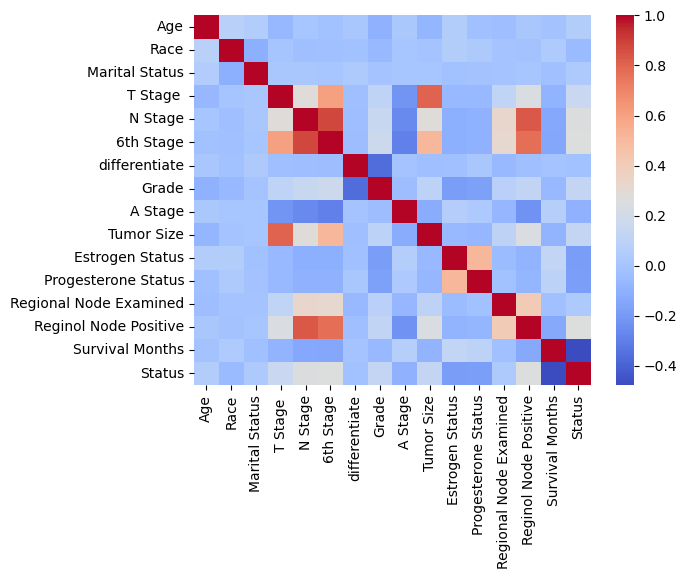

In [20]:
corr = df.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.show()

Nenhuma coluna apresentou correlação alta com outra, contudo eliminamos as colunas Race e Marital Status por serem irrelevantes para a classificação.

In [21]:
columns_to_remove = ['Race', 'Marital Status']
df.drop(columns=columns_to_remove, inplace=True)

### Separar em Features e labels

In [22]:
X, y = df.drop(columns=["Status"]), df["Status"]

### Balanceamento de classes

In [23]:
y.value_counts(normalize=True)

Status
0    0.846918
1    0.153082
Name: proportion, dtype: float64

In [24]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

y_res.value_counts(normalize=True), y_res.shape

(Status
 0    0.5
 1    0.5
 Name: proportion, dtype: float64,
 (1232,))

### Separar em treino e teste

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res, test_size=0.2,
                                                                    random_state=42)

### Seleção de parâmetros

In [26]:
""" params = [
    {'n_estimators': [10, 50, 100, 200, 500], 'criterion': ['gini', 'entropy']},
]

models = [RandomForestClassifier()]

for model, param in zip(models, params):
    grid = GridSearchCV(model, param, cv=5, n_jobs=-1)
    grid.fit(X_res_train, y_res_train)
    print(f"{model.__class__.__name__} : {grid.best_params_}") """

' params = [\n    {\'n_estimators\': [10, 50, 100, 200, 500], \'criterion\': [\'gini\', \'entropy\']},\n]\n\nmodels = [RandomForestClassifier()]\n\nfor model, param in zip(models, params):\n    grid = GridSearchCV(model, param, cv=5, n_jobs=-1)\n    grid.fit(X_res_train, y_res_train)\n    print(f"{model.__class__.__name__} : {grid.best_params_}") '

### Treinar os modelos e realizar classificação

In [27]:
rf_res = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')

# Treino dos modelos
rf_res.fit(X_res_train, y_res_train)
rf.fit(X_train, y_train)

# Predição dos modelos
predict_rf_res = rf_res.predict(X_res_test)
predict_rf = rf.predict(X_test)

### Avaliação

In [28]:
predicts = [predict_rf_res, predict_rf]
names = ["RF Balanced", "RF"]
ys = [y_res_test, y_test]

accuracies = []
precisions = []
recalls = []
f1s = []

for current_y, predict in zip(ys, predicts):
    accuracies.append(accuracy_score(current_y, predict) * 100)
    precisions.append(precision_score(current_y, predict, average='macro') * 100)
    recalls.append(recall_score(current_y, predict, average='macro') * 100)
    f1s.append(f1_score(current_y, predict, average='macro') * 100)
    
metrics = pd.DataFrame({
    "Model": names,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1": f1s
})

metrics

,Model,Accuracy,Precision,Recall,F1
0,RF Balanced,77.327935,77.666084,77.029957,77.093270
1,RF,90.807453,86.436573,73.978102,78.314841
